In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from tensorflow.keras import backend as K

In [3]:
d=pd.read_csv(r"C:\Users\Ishan Khan\StockPrediction\data\raw\semi_conductor_se.csv")
d_1=pd.read_csv(r"C:\Users\Ishan Khan\StockPrediction\data\raw\semi_conductor_se.csv")
print(d_1.head())

   Unnamed: 0 company_name stock_name        date      open      high  \
0           0       NVIDIA       NVDA  2012-01-03  0.327805  0.330097   
1           1       NVIDIA       NVDA  2012-01-04  0.322074  0.326888   
2           2       NVIDIA       NVDA  2012-01-05  0.323908  0.338808   
3           3       NVIDIA       NVDA  2012-01-06  0.336974  0.337204   
4           4       NVIDIA       NVDA  2012-01-09  0.333536  0.339725   

        low     close     volume  
0  0.321157  0.321845  468044000  
1  0.319094  0.325513  347372000  
2  0.322533  0.337204  563548000  
3  0.329410  0.333307  533252000  
4  0.331014  0.333307  508244000  


In [4]:
le = LabelEncoder()
d["company_name"] = le.fit_transform(d["company_name"])
print(d.head())

   Unnamed: 0  company_name stock_name        date      open      high  \
0           0            78       NVDA  2012-01-03  0.327805  0.330097   
1           1            78       NVDA  2012-01-04  0.322074  0.326888   
2           2            78       NVDA  2012-01-05  0.323908  0.338808   
3           3            78       NVDA  2012-01-06  0.336974  0.337204   
4           4            78       NVDA  2012-01-09  0.333536  0.339725   

        low     close     volume  
0  0.321157  0.321845  468044000  
1  0.319094  0.325513  347372000  
2  0.322533  0.337204  563548000  
3  0.329410  0.333307  533252000  
4  0.331014  0.333307  508244000  


In [5]:
X_num_train, X_num_test = [], []
X_comp_train, X_comp_test = [], []
y_train, y_test = [], []

scalers = {} 

features=["high","low","open","volume"]

SEQ_LEN=60

for company in d['company_name'].unique():
    sub = d[d['company_name'] == company].sort_values("date")
    data = sub[features].values
    comp = sub['company_name'].values
    target = sub[['close']].values
    
    split_index = int(0.8 * len(sub))

    scaler_num = MinMaxScaler()
    scaler_num.fit(data[:split_index])

    scaler_target = MinMaxScaler()
    scaler_target.fit(target[:split_index])

    scalers[company] = {
        "num": scaler_num,
        "target": scaler_target
    }

    data_scaled = scaler_num.transform(data)
    target_scaled = scaler_target.transform(target)

    X_num_company, X_comp_company, y_company = [], [], []
    for i in range(len(sub) - SEQ_LEN):
        X_num_company.append(data_scaled[i:i+SEQ_LEN])
        X_comp_company.append(comp[i+SEQ_LEN])
        y_company.append(target_scaled[i+SEQ_LEN])

    X_num_company = np.array(X_num_company)
    X_comp_company = np.array(X_comp_company)
    y_company = np.array(y_company)

    X_num_train.append(X_num_company[:split_index-SEQ_LEN])
    X_num_test.append(X_num_company[split_index-SEQ_LEN:])
    X_comp_train.append(X_comp_company[:split_index-SEQ_LEN])
    X_comp_test.append(X_comp_company[split_index-SEQ_LEN:])
    y_train.append(y_company[:split_index-SEQ_LEN])
    y_test.append(y_company[split_index-SEQ_LEN:])




In [7]:
X_num_train = np.concatenate(X_num_train)
X_num_test = np.concatenate(X_num_test)
X_comp_train = np.concatenate(X_comp_train)
X_comp_test = np.concatenate(X_comp_test)
y_train = np.concatenate(y_train)
y_test = np.concatenate(y_test)

In [8]:
num_companies = d['company_name'].nunique()
num_features = len(features)
embedding_dim = min(50, num_companies // 2) 
SEQ_LEN = 60

inp_num = layers.Input(shape=(SEQ_LEN, num_features)) 
inp_comp = layers.Input(shape=(1,))                    

emb = layers.Embedding(input_dim=num_companies, output_dim=embedding_dim)(inp_comp)
emb = layers.Flatten()(emb)
emb = layers.RepeatVector(SEQ_LEN)(emb)

x = layers.Concatenate()([inp_num, emb])

x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(32, return_sequences=True))(x)

attn_hidden = layers.Dense(64, activation="tanh")(x)   
attn_logits = layers.Dense(1)(attn_hidden)            
attn_weights = layers.Softmax(axis=1)(attn_logits)    

x = layers.Multiply()([x, attn_weights])               
x = layers.Lambda(lambda z: K.sum(z, axis=1))(x) 

out = layers.Dense(1)(x)

model = Model(inputs=[inp_num, inp_comp], outputs=out)
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │      7,600 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 60, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 60, 50)    │          0 │ flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 54)    │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 60, 128)   │     46,080 │ concatenate[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 60, 64)    │     31,104 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 60, 64)    │      4,160 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 60, 1)     │         65 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 60, 1)     │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 60, 64)    │          0 │ bidirectional_1[… │
│                     │                   │            │ softmax[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,074 (347.95 KB)

 Trainable params: 89,074 (347.95 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit([X_num_train, X_comp_train], y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
8226/8226 ━━━━━━━━━━━━━━━━━━━━ 385s 46ms/step - loss: 0.0017 - val_loss: 5.1471e-04
Epoch 2/10
8226/8226 ━━━━━━━━━━━━━━━━━━━━ 256s 31ms/step - loss: 2.7860e-04 - val_loss: 4.4727e-04
Epoch 3/10
8226/8226 ━━━━━━━━━━━━━━━━━━━━ 250s 30ms/step - loss: 2.6545e-04 - val_loss: 4.0734e-04
Epoch 4/10
8226/8226 ━━━━━━━━━━━━━━━━━━━━ 255s 31ms/step - loss: 2.6074e-04 - val_loss: 4.0972e-04
Epoch 5/10
8226/8226 ━━━━━━━━━━━━━━━━━━━━ 258s 31ms/step - loss: 2.5809e-04 - val_loss: 4.0926e-04
Epoch 6/10
8226/8226 ━━━━━━━━━━━━━━━━━━━━ 255s 31ms/step - loss: 2.6179e-04 - val_loss: 4.2635e-04
Epoch 7/10
8226/8226 ━━━━━━━━━━━━━━━━━━━━ 252s 31ms/step - loss: 2.5569e-04 - val_loss: 4.2224e-04
Epoch 8/10
8226/8226 ━━━━━━━━━━━━━━━━━━━━ 250s 30ms/step - loss: 2.5005e-04 - val_loss: 4.1169e-04
Epoch 9/10
8226/8226 ━━━━━━━━━━━━━━━━━━━━ 250s 30ms/step - loss: 2.5176e-04 - val_loss: 4.5585e-04
Epoch 10/10
8226/8226 ━━━━━━━━━━━━━━━━━━━━ 258s 31ms/step - loss: 2.5202e-04 - val_loss: 4.1267e-04


In [14]:
def plot_company(company_name):
    company_code = le.transform([company_name])[0]

    mask = (X_comp_test == company_code)
    X_num_c = X_num_test[mask]
    X_comp_c = X_comp_test[mask]
    y_test_c = y_test[mask]

    y_pred = model.predict([X_num_c, X_comp_c], verbose=0)
    
    scaler = scalers[company_code]["target"]
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test_c.reshape(-1, 1))

    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

    print(f" {company_name} Performance:")
    print(f"  R²  = {r2:.4f}")
    print(f"  MSE = {mse:.4f}")
    print(f"  MAE = {mae:.4f}")

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(y_test_rescaled, label=f"Actual {company_name}")
    plt.plot(y_pred_rescaled, label=f"Predicted {company_name}")
    plt.legend()
    plt.title(f"Stock Price Prediction: {company_name}")
    plt.xlabel("Time steps (test set)")
    plt.ylabel("Price")
    plt.show()


 AMD Performance:
  R²  = 0.9745
  MSE = 27.4149
  MAE = 3.8202


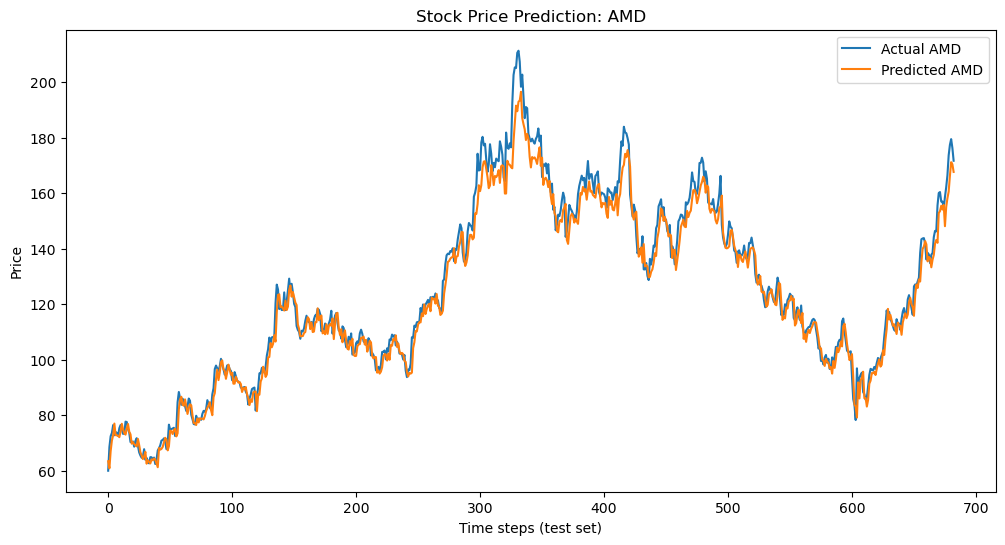

 Intel Performance:
  R²  = 0.9861
  MSE = 0.8567
  MAE = 0.6613


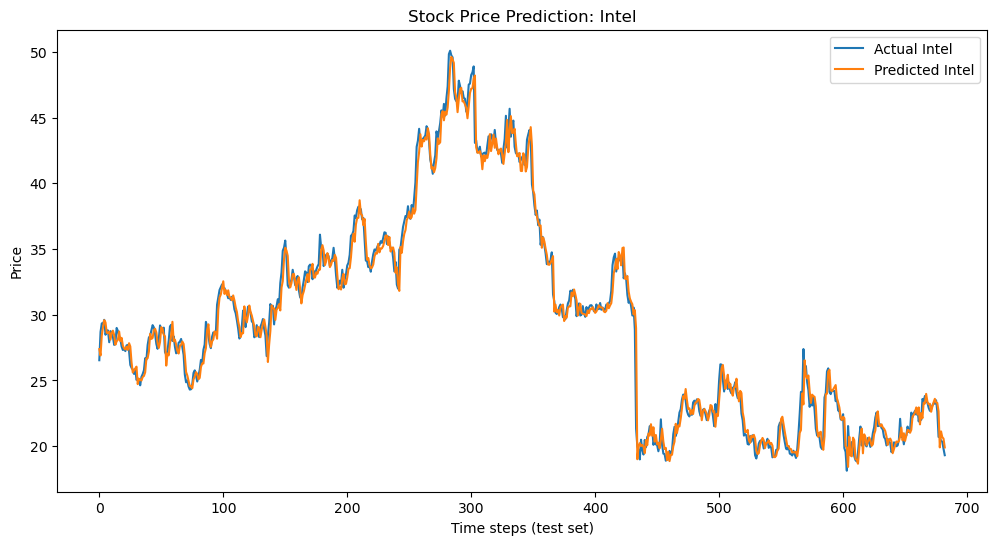

 CEVA Performance:
  R²  = 0.9390
  MSE = 1.2767
  MAE = 0.8375


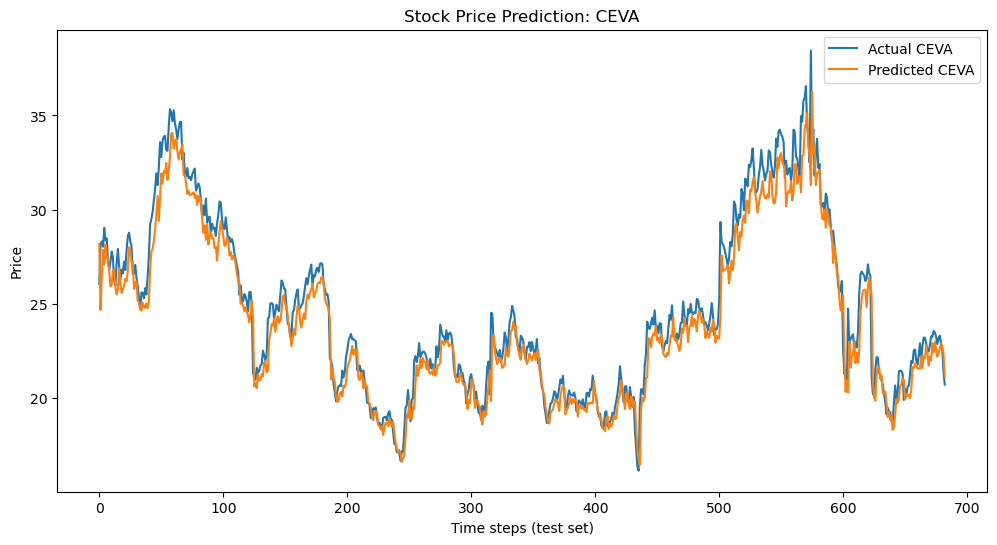

 NVIDIA Performance:
  R²  = -0.3574
  MSE = 2963.2740
  MAE = 39.3133


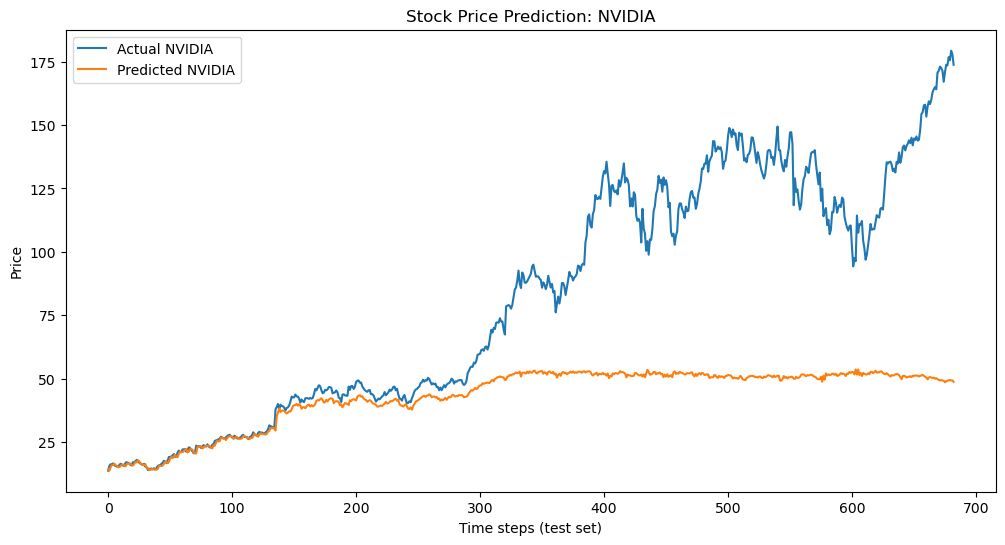

In [15]:
plot_company("AMD")
plot_company("Intel")
plot_company("CEVA")
plot_company("NVIDIA")

In [16]:
X_num_train_nvidia, X_num_test_nvidia = [], []
y_train_nvidia, y_test_nvidia = [], []

sub_1 = d_1[d_1['company_name']=="NVIDIA"].sort_values("date")
data_1 = sub_1[features].values
target_1 = sub_1[['close']].values

split_index_1 = int(0.8 * len(data_1))

scaler_num_nvidia = MinMaxScaler()
scaler_num_nvidia.fit(data_1[:split_index_1])
data_scaled_1 = scaler_num_nvidia.transform(data_1)

scaler_target_nvidia = MinMaxScaler()
scaler_target_nvidia.fit(target_1[:split_index_1])
target_scaled_1 = scaler_target_nvidia.transform(target_1)

X_num_nvidia, y_nvidia = [], []
for i in range(len(sub_1) - SEQ_LEN):  
    X_num_nvidia.append(data_scaled_1[i:i+SEQ_LEN])
    y_nvidia.append(target_scaled_1[i+SEQ_LEN])

X_num_nvidia = np.array(X_num_nvidia)
y_nvidia     = np.array(y_nvidia)

X_num_train_nvidia = X_num_nvidia[:split_index_1-SEQ_LEN]
X_num_test_nvidia  = X_num_nvidia[split_index_1-SEQ_LEN:]

y_train_nvidia = y_nvidia[:split_index_1-SEQ_LEN]
y_test_nvidia  = y_nvidia[split_index_1-SEQ_LEN:]

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model_2 = Sequential()
model_2.add(LSTM(128, return_sequences=True))
model_2.add(LSTM(64, return_sequences=False))
model_2.add(Dense(25))
model_2.add(Dense(1))

model_2.compile(optimizer='adam', loss='mean_squared_error')

history_2 = model_2.fit(X_num_train_nvidia, y_train_nvidia, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.3529e-05 - val_loss: 0.0022
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.4917e-05 - val_loss: 0.0022
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.2596e-05 - val_loss: 0.0019
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 5.2713e-05 - val_loss: 0.0018
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 4.1036e-05 - val_loss: 0.0022
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 6.3258e-05 - val_loss: 0.0017
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.8729e-05 - val_loss: 0.0015
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.6265e-05 - val_loss: 0.0019
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.4296e-05 - val_loss: 0.0012


r2: 0.7128927944771438
MSE: 626.7470846349918
MAE: 17.28990811170631


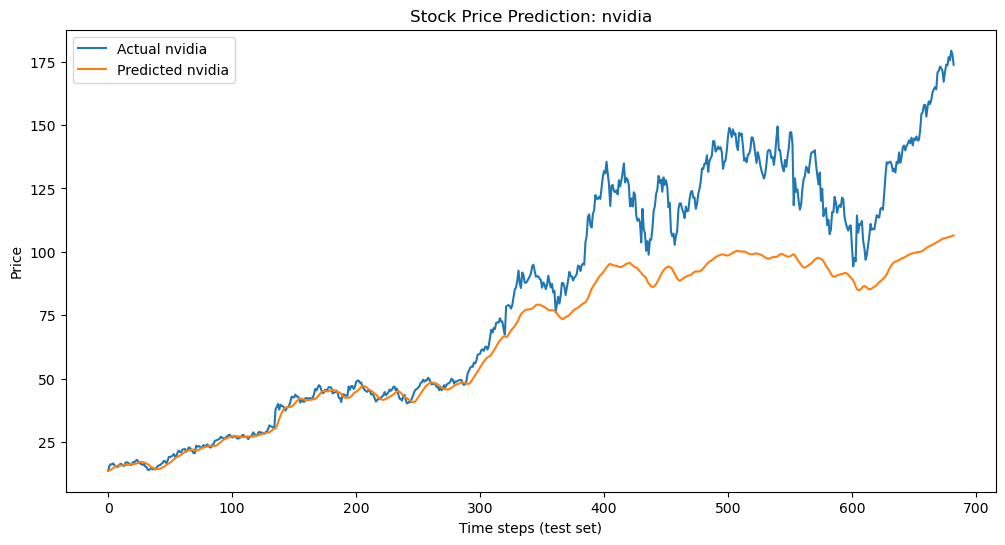

In [19]:
y_pred_1 = model_2.predict(X_num_test_nvidia, verbose=0)

y_pred_rescaled_2 = scaler_target_nvidia.inverse_transform(y_pred_1.reshape(-1, 1))
y_test_rescaled_2 = scaler_target_nvidia.inverse_transform(y_test_nvidia.reshape(-1, 1))

r2_1 = r2_score(y_test_rescaled_2, y_pred_rescaled_2)
mse = mean_squared_error(y_test_rescaled_2, y_pred_rescaled_2)
mae = mean_absolute_error(y_test_rescaled_2, y_pred_rescaled_2)
print("r2:", r2_1)
print("MSE:",mse)
print("MAE:",mae)

plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled_2, label="Actual nvidia")
plt.plot(y_pred_rescaled_2, label="Predicted nvidia")
plt.legend()
plt.title("Stock Price Prediction: nvidia")
plt.xlabel("Time steps (test set)")
plt.ylabel("Price")
plt.show()